# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель исследования**
  
Создать систему рекомендаций тарифов на основе данных о использовании мобильной сети и мобильного трафика пользователями

**Ход исследования**

 - Сформируем обучающую, валидационную и тестовую выборки
 - Изучим точность нескольких моделей: `дерева решений`, `случайного леса` и `логистической регрессии`
 - Проверим наиболее точную модель на тестовой выборке
 - проверим наиболее точную модель в тесте на адекватность

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

In [2]:
df = pd.read_csv('users_behavior.csv')
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


## Разбейте данные на выборки

Разобьем данные на три части - для обучения, валидации и теста в соотношении 60%:20%:20%

In [3]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

features_train, features_valid_test, target_train, target_valid_test = train_test_split(
    features, target, test_size=0.4, random_state=123)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_test, target_valid_test, test_size=0.5, random_state=321)

## Исследуйте модели

### Дерево решений

Первая модель для исследования - дерево решений. Попробуем глубину дерева от 1 до 20 и выберем самую удачную

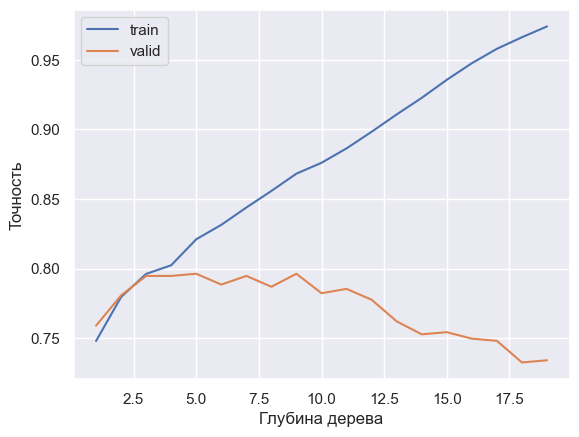

Оптимальная глубина: 5
Лучшая точность: 0.7962674961119751


In [4]:
def decision_tree(return_model=False):
    accuracy_train = []
    accuracy_valid = []
    best_accuracy = 0
    best_depth = 0

    for depth in range(1, 20):
        model = DecisionTreeClassifier(max_depth=depth, random_state=123)
        model.fit(features_train, target_train)

        answers_train = model.predict(features_train)
        answers_valid = model.predict(features_valid)

        accuracy_train.append(accuracy_score(target_train, answers_train))
        accuracy_valid.append(accuracy_score(target_valid, answers_valid))

        if accuracy_valid[depth - 1] > best_accuracy:
            best_accuracy = accuracy_valid[depth - 1]
            best_depth = depth
            best_model = model

    sns.set()
    xaxis = range(1, len(accuracy_train)+1)
    sns.lineplot(x=xaxis, y=accuracy_train, label='train')
    sns.lineplot(x=xaxis, y=accuracy_valid, label='valid')
    plt.xlabel('Глубина дерева')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальная глубина:', best_depth)
    print('Лучшая точность:', best_accuracy)

decision_tree()

Видно, что модель начинает переобучаться, если задать слишком высокий гиперпараметр глубины

### Лес деревьев

Следующая модель - лес деревьев. Его обучение и перебор количества деревьев займет больше времени, но и точность ожидается выше

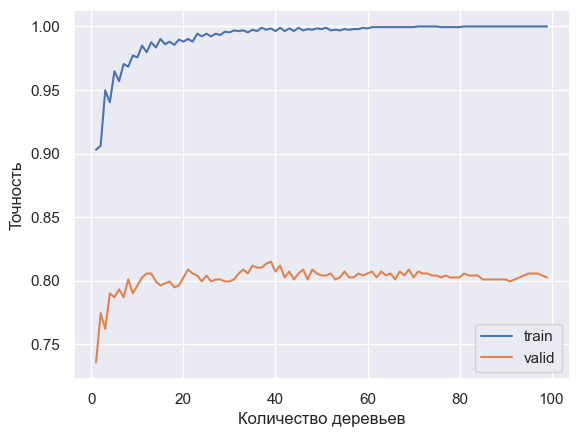

Оптимальное количество деревьев: 39
Лучшая точность: 0.8149300155520995


In [5]:
def random_forest():
    accuracy_train = []
    accuracy_valid = []
    best_accuracy = 0
    best_est = 0

    for est in range(1, 100):
        model = RandomForestClassifier(n_estimators=est, random_state=123)
        model.fit(features_train, target_train)

        answers_train = model.predict(features_train)
        answers_valid = model.predict(features_valid)

        accuracy_train.append(accuracy_score(target_train, answers_train))
        accuracy_valid.append(accuracy_score(target_valid, answers_valid))

        if accuracy_valid[est - 1] > best_accuracy:
            best_accuracy = accuracy_valid[est - 1]
            best_est = est

    sns.set()
    xaxis = range(1, len(accuracy_train)+1)
    sns.lineplot(x=xaxis, y=accuracy_train, label='train')
    sns.lineplot(x=xaxis, y=accuracy_valid, label='valid')
    plt.xlabel('Количество деревьев')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальное количество деревьев:', best_est)
    print('Лучшая точность:', best_accuracy)

random_forest()

Узнали, что нет смысла "растить" больше 39 деревьев в одном лесу

### Логистическая регрессия

Модель - логистическая регрессия. У нее попробуем поменять гиперпараметр итераций обучения от 100 до 1000 с шагом в 100

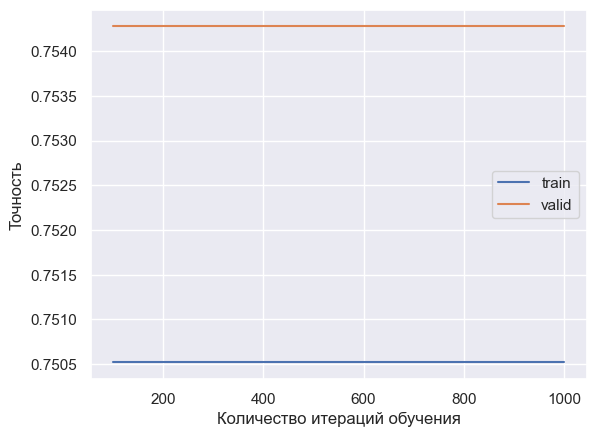

Оптимальное количество итераций обучения: 100
Лучшая точность: 0.7542768273716952


In [6]:
def logistic_regression():
    accuracy_train = []
    accuracy_valid = []
    best_accuracy = 0
    best_iter = 0

    for iterations in range(100, 1001, 100):
        model = LogisticRegression(max_iter=iterations, random_state=123)
        model.fit(features_train, target_train)

        answers_train = model.predict(features_train)
        answers_valid = model.predict(features_valid)

        accuracy_train.append(accuracy_score(target_train, answers_train))
        accuracy_valid.append(accuracy_score(target_valid, answers_valid))

        if accuracy_valid[iterations//100 - 1] > best_accuracy:
            best_accuracy = accuracy_valid[iterations//100 - 1]
            best_iter = iterations

    sns.set()
    xaxis = range(100, len(accuracy_train)*100+1, 100)
    sns.lineplot(x=xaxis, y=accuracy_train, label='train')
    sns.lineplot(x=xaxis, y=accuracy_valid, label='valid')
    plt.xlabel('Количество итераций обучения')
    plt.ylabel('Точность')
    plt.show()
    print('Оптимальное количество итераций обучения:', best_iter)
    print('Лучшая точность:', best_accuracy)

logistic_regression()

Гиперпараметр никак не повлиял на точность обученной модели

### Итог
---
По итогам, наиболее точной в предсказаниях оказалась модель случайного леса. Ее мы дальше и проверим на тестовой выборке, а также на адекватность

## Проверьте модель на тестовой выборке

In [7]:
best_model = RandomForestClassifier(n_estimators=39, random_state=123)
best_model.fit(features_train, target_train)
answers_test = best_model.predict(features_test)
print('Точность на тестовой выборке', accuracy_score(target_test, answers_test))

Точность на тестовой выборке 0.8164852255054432


Точность оказалась на уровне валидирующей выборки, что ожидаемо

## (бонус) Проверьте модели на адекватность

In [8]:
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(features_train, target_train)
dummyclassifier_answers = dummy_classifier.predict(features_test)
print('Точность случайной модели', accuracy_score(target_test, dummyclassifier_answers))

Точность случайной модели 0.6920684292379471


Точность модели, которая всегда будет отвечать 0 или 1(тот ответ, которого в обучающей выборке большинство) составляет 0.69, а у нашей 0.81. Это значит, наша модель пусть немного, но все же умнее случайной

## Итог

При создании системы рекомендаций протестировали три типа модели:
- Дерево решений
- Случайный лес
- Логистическая регрессия

Самой точной оказалась `модель Случайного леса` - с точностью 0.81, которая также усппешно прошла проверку на адекватность.

При изменении случайного распределения и обучения(random_state) могут незначительно меняться оптимальные гиперпараметры для моделей, а также точность. Но модель случайного леса всегда остается самой точной и проходит тест на адекватность

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
